In [ ]:
import numpy as np
import torch
import torch.nn as nn
import re
import torch.nn.functional as F
from torch.autograd import Function
from torch.utils.data import DataLoader, Dataset
import csv
import pandas as pd

In [ ]:
def seqToString(sequence):
    seq_string = str(sequence)
    seq_string = re.sub('[^ACGT]', 'N', seq_string)
    return seq_string


def ordinal_encoder(sequence):
    seq_string = seqToString(sequence)

    mapping = {
        'a': 1,
        'c': 2,
        'g': 3,
        't': 4,
        'n': 5
    }

    float_encoded = np.array([mapping[label] for label in seq_string])
    return float_encoded


def create_dictionary():
  alphabet = ['A', 'C', 'G', 'T', 'N']

  vocab = dict()
  i = 0

  for letter1 in alphabet:
    for letter2 in alphabet:
      for letter3 in alphabet:
        for letter4 in alphabet:
          for letter5 in alphabet:
            word = letter1 + letter2 + letter3 + letter4 + letter5
            vocab[word] = i
            i +=1
  return vocab

In [ ]:
class LSTMEmbedding(nn.Module):

    def __init__(self, embedding_dim, hidden_dim):
        super(LSTMEmbedding, self).__init__()
        self.hidden_dim = hidden_dim

        self.word_embeddings = nn.Embedding(3_125, embedding_dim)

        # The LSTM takes word embeddings as inputs, and outputs hidden states
        # with dimensionality hidden_dim.

        self.lstm = nn.LSTM(embedding_dim, hidden_dim)
        self.hidden2repr = nn.Linear(hidden_dim, 1)

    def forward(self, data):
        embeds = self.word_embeddings(data)
        # lstm_out = self.lstm(embeds.view(len(sentence), 1, -1))

        lstm_out, _ = self.lstm(embeds)
        repr = self.hidden2repr(lstm_out)

        return repr


In [ ]:
class DNADataset(Dataset):
    def __init__(self, sequences):
        self.sequences = sequences

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        return  torch.FloatTensor(self.sequences[idx][0]), torch.FloatTensor(self.sequences[idx][1]), self.sequences[idx][2]

In [ ]:
dataset = pd.read_csv('/content/drive/MyDrive/datset.csv')
word_dict = create_dictionary()
display(dataset)
dataset['seq1'] = dataset['seq1'].apply(lambda x: [word_dict[seqToString(x[i:i+5])] for i in range(0, len(x)-4, 5)])
dataset['seq2'] = dataset['seq2'].apply(lambda x: [word_dict[seqToString(x[i:i+5])] for i in range(0, len(x)-4, 5)])
dataset['score'] = dataset['score']/500
display(dataset)
data = dataset.values.tolist()

,seq1,seq2,score
0,AGTGTTGGATTCAAAGCTGGTGTTAAAGATTACAAATTGACTTATT...,ATGTTTTTTTTTTCAACCGAAGAAACCCCAGAACCTGGAGGAGTAG...,305.0
1,GGTGTTGGATTTCAAGCTGGTGTTAAAGATTATAAATTGACTTACT...,GAAACTAAAGCAAGTGTTGGATTCAAAGCTGGTGTTAAAGATTATA...,446.0
2,TAAAGCAGGTACTGGATTCAAAGCTGGTGTTAAAGATTACAAATTG...,AGATTATAAATTGACTTACTACACCCCGGAGTATGAAACCAAGGAT...,420.0
3,AAACAGAGACTAAAGCAAGTGTTGGATTCAAAGCCGGTGTTAAAGA...,GTATGGAAACCTACCAAGTGATAACTTTCAAATTCAGAGAAACCCT...,317.0
4,TATTTACTTACTTTTGAAGGACATTTAAATGTTTATTTTCAAAATT...,TTATTACACGCCTGATTATCAAGTAAAAGATACTGATATTTTAGCA...,322.0
...,...,...,...
49995,CTACGCACGTATTTCCCCCCCCAACAGAAACTAAAGCTTTTGTTGG...,ACAGAAACTAAAGCAAGTGTTGGATTTAAAGCTGGTGTTAAGGATT...,426.0
49996,AGATTGACTTATTATACTCCTGATTACGAAACCAAAGATACTGATA...,TTTTTTGTGAAAATTATCGAATCCAAAAAAAAAATGTCCGATAGCA...,310.0
49997,AAGATTACAAATTGACTTATTATACTCCTGACTATGAAACCAAAGA...,ATGTTTTTTTTTTCAACCGAAGAAACCCCAGAACCTGGAGGAGTAG...,299.0
49998,TTAAATAAGAAATAGGAGTTAGCAATCCATGGTACCAGCAAAAGGA...,TTTTTTGTCAAGCGCGGAAACCGCAGAACCCGAAGTAGTAGGATTT...,331.0


,seq1,seq2,score
0,"[338, 2178, 2000, 1462, 2215, 53, 1900, 460, 1...","[443, 2343, 2330, 160, 250, 780, 1256, 2177, 1...",0.610
1,"[1588, 2178, 2275, 1462, 2215, 53, 1950, 460, ...","[1251, 1877, 638, 1712, 455, 58, 1588, 1877, 4...",0.892
2,"[1877, 688, 212, 455, 58, 1588, 1877, 451, 18,...","[268, 375, 2301, 2258, 131, 810, 1642, 6, 60, ...",0.840
3,"[5, 1301, 1877, 638, 1712, 455, 56, 1588, 1877...","[1642, 1251, 1006, 67, 376, 2330, 91, 260, 31,...",0.634
4,"[1968, 215, 1093, 1262, 143, 1878, 1715, 2341,...","[2268, 132, 835, 2266, 65, 10, 1917, 393, 2261...",0.644
...,...,...,...
49995,"[1007, 663, 466, 781, 751, 250, 1000, 1468, 22...","[135, 40, 55, 338, 2178, 2250, 1462, 2215, 303...",0.852
49996,"[268, 1293, 453, 206, 2143, 175, 150, 265, 105...","[2343, 2210, 18, 410, 405, 0, 3, 1657, 386, 18...",0.620
49997,"[53, 1900, 460, 1078, 1951, 2042, 203, 1251, 6...","[443, 2343, 2330, 160, 250, 780, 1256, 2177, 1...",0.598
49998,"[2250, 1885, 77, 1318, 275, 2028, 1576, 680, 1...","[2343, 2205, 286, 1500, 805, 1256, 877, 1940, ...",0.662


In [ ]:
training_id = np.random.randint(0, 50_000, size=35_000)
training = list()
test = list()

for idx, datapoint in enumerate(data):
  if idx in training_id:
    training.append(datapoint)
  else:
    test.append(datapoint)


In [ ]:
def cosine_distance(x, y):
    return 1 - torch.nn.functional.cosine_similarity(x, y)

input_size = 500
hidden_size = 100

model = LSTMEmbedding(input_size, hidden_size)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

training_set = DNADataset(training)
test_set = DNADataset(test)

train_dataloader = DataLoader(training_set, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_set, batch_size=32, shuffle=True)

epochs = 20

criterion = nn.MSELoss()

losses = list()
# losses.to('cuda')
model = model.to('cuda')

for epoch in range(epochs):
    batch_loses = list()
    for seq1, seq2, target in train_dataloader:
        seq1 = seq1.int().to('cuda')
        seq2 = seq2.int().to('cuda')
        target = target.float().to('cuda').squeeze()

        optimizer.zero_grad()


        embedded_seq1 = model(seq1)
        embedded_seq2 = model(seq2)

        real = cosine_distance(embedded_seq1, embedded_seq2)

        loss = criterion(target, real)
        batch_loses.append(loss)

        loss.backward()
        optimizer.step()

    print(f"Batch loss is {torch.mean(torch.tensor(batch_loses))}")
    losses.append(torch.mean(torch.tensor(batch_loses)))

    print("Training epoch {ep} done".format(ep=epoch))

torch.save(model.state_dict(), 'linear.pth')

Batch loss is 0.016120905056595802
Training epoch 0 done
Batch loss is 0.01490924134850502
Training epoch 1 done
Batch loss is 0.014443263411521912
Training epoch 2 done
Batch loss is 0.014279928989708424
Training epoch 3 done
Batch loss is 0.014084439724683762
Training epoch 4 done
Batch loss is 0.013900184072554111
Training epoch 5 done
Batch loss is 0.013855804689228535
Training epoch 6 done
Batch loss is 0.013775366358458996
Training epoch 7 done
Batch loss is 0.013713053427636623
Training epoch 8 done
Batch loss is 0.013626941479742527
Training epoch 9 done
Batch loss is 0.01356524508446455
Training epoch 10 done
Batch loss is 0.013512596487998962
Training epoch 11 done
Batch loss is 0.013490036129951477
Training epoch 12 done
Batch loss is 0.013430971652269363
Training epoch 13 done
Batch loss is 0.013404227793216705
Training epoch 14 done
Batch loss is 0.013358181342482567
Training epoch 15 done
Batch loss is 0.013351066038012505
Training epoch 16 done
Batch loss is 0.0133128501

In [ ]:
for epoch in range(epochs):
    batch_loses = list()
    for seq1, seq2, target in train_dataloader:
        seq1 = seq1.int().to('cuda')
        seq2 = seq2.int().to('cuda')
        target = target.float().to('cuda').squeeze()

        optimizer.zero_grad()


        embedded_seq1 = model(seq1)
        embedded_seq2 = model(seq2)

        real = cosine_distance(embedded_seq1, embedded_seq2)

        loss = criterion(target, real)
        batch_loses.append(loss)

        loss.backward()
        optimizer.step()

    print(f"Epoch loss is {torch.mean(torch.tensor(batch_loses))}")
    losses.append(torch.mean(torch.tensor(batch_loses)))

    print("Training epoch {ep} done".format(ep=epoch))

torch.save(model.state_dict(), 'linear.pth')

Epoch loss is 0.013077442534267902
Training epoch 0 done
Epoch loss is 0.013059050776064396
Training epoch 1 done
Epoch loss is 0.01310849841684103
Training epoch 2 done
Epoch loss is 0.013058601878583431
Training epoch 3 done
Epoch loss is 0.013041913509368896
Training epoch 4 done
Epoch loss is 0.013021857477724552
Training epoch 5 done
Epoch loss is 0.013044661842286587
Training epoch 6 done
Epoch loss is 0.013026999309659004
Training epoch 7 done
Epoch loss is 0.013022924773395061
Training epoch 8 done
Epoch loss is 0.013014529831707478
Training epoch 9 done
Epoch loss is 0.01300789974629879
Training epoch 10 done
Epoch loss is 0.012999767437577248
Training epoch 11 done
Epoch loss is 0.013032454065978527
Training epoch 12 done
Epoch loss is 0.012994620949029922
Training epoch 13 done
Epoch loss is 0.012982763350009918
Training epoch 14 done
Epoch loss is 0.012979583814740181
Training epoch 15 done
Epoch loss is 0.013000809587538242
Training epoch 16 done
Epoch loss is 0.0130172735

60
0.016120905


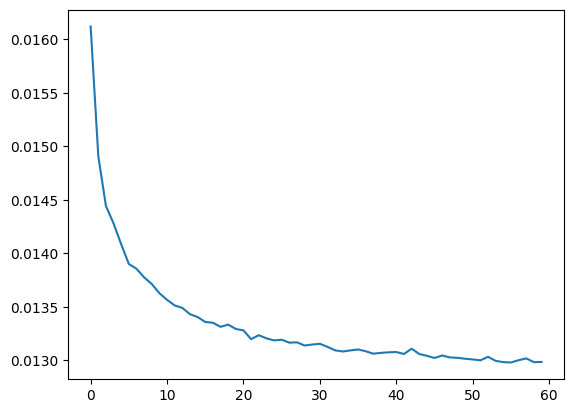

In [ ]:
import matplotlib.pyplot as plt

np_losses = [loss.cpu().detach().numpy() for loss in losses]
print(len(np_losses))
print(np_losses[0])
plt.plot(np_losses)
plt.show()